In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN 

import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'MSFT' #MicroSoft
ticker = yf.Ticker(name)
ori_df = ticker.history(interval='1d', period='10y', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

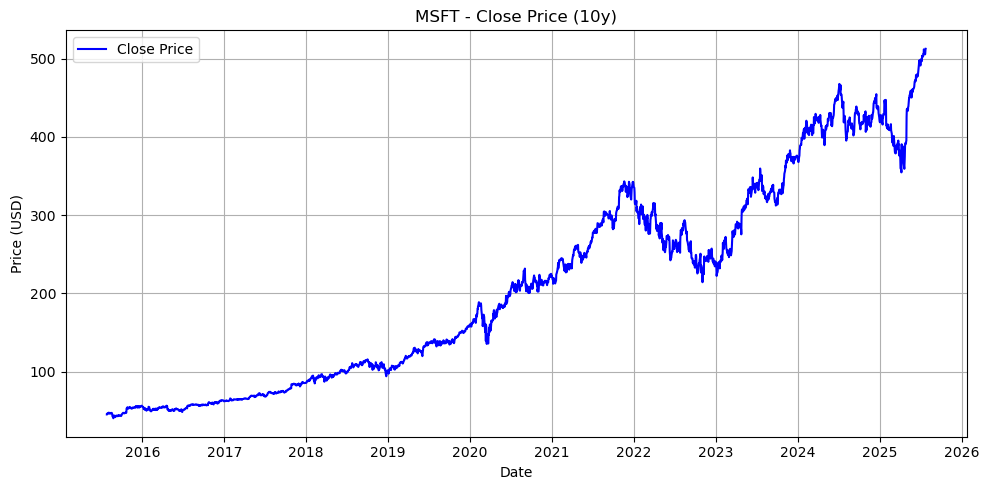

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

In [7]:
df_with_cpm.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,is_cpm_point,cpm_point_type
Date,,,,,,,,,,
2015-07-27 00:00:00-04:00,45.939999,46.009998,45.250000,45.349998,39.322559,39701400,0.0,0.0,True,0
2015-07-28 00:00:00-04:00,45.580002,45.639999,44.790001,45.340000,39.313889,34328900,0.0,0.0,False,0
2015-07-29 00:00:00-04:00,45.400002,46.779999,45.259998,46.290001,40.137634,40945900,0.0,0.0,False,0
2015-07-30 00:00:00-04:00,46.259998,47.400002,45.930000,46.880001,40.649208,39777900,0.0,0.0,False,0
2015-07-31 00:00:00-04:00,47.290001,47.369999,46.500000,46.700001,40.493126,31201500,0.0,0.0,False,0


In [8]:
len(cpm_points)

1289

In [9]:
df_with_cpm['cpm_point_type'].describe()

count    2515.000000
mean        0.001193
std         0.715494
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: cpm_point_type, dtype: float64

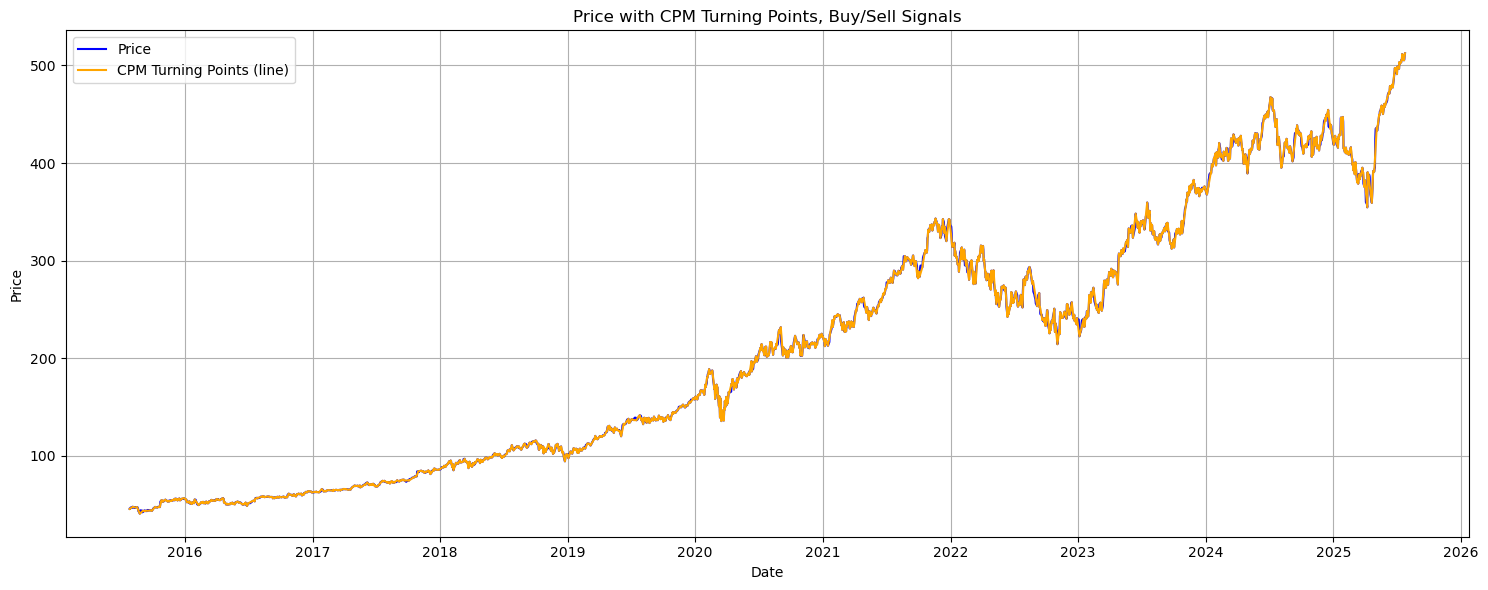

In [10]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [12]:
total_len = len(df)

# # 6:2:2
# train_end = int(total_len * 0.6)
# val_end = int(total_len * 0.8)

# train_df = df.iloc[:train_end]
# val_df = df.iloc[train_end:val_end]
# test_df = df.iloc[val_end:]

train_end = int(total_len * 0.7)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [13]:
st_best_params, st_best_fitness, train_df = st.run_stochastic_ga_optimization(train_df)

print("Best Parameters:", st_best_params)
print("Best Fitness:", st_best_fitness)

유전 알고리즘 실행 중...


KeyboardInterrupt: 

In [ ]:
n, a, b, c, d = st_best_params

In [15]:
test_st_signals = st.generate_stochastic_signals(test_df, n, a, b, c, d)

In [16]:
signal_map = test_st_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['ST_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_12032\1151066698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ST_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [14]:
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	2509.82	2477.79	2570.76
1  	38    	inf    	2476.17	inf    
2  	36    	inf    	2477.69	inf    
3  	36    	2489.15	2466.59	2535.86
4  	28    	inf    	2466.59	inf    
5  	40    	2490.31	2468.85	2533.41
6  	46    	inf    	2445.41	inf    
7  	35    	2487.67	2445.41	2520.06
8  	34    	2482.7 	2445.41	2525.18
9  	32    	2478.93	2445.41	2536.04
10 	32    	2478.64	2445.41	2533.66
11 	36    	inf    	2445.41	inf    
12 	37    	2455.79	2444.15	2522.71
13 	32    	2451.62	2436.88	2498.75
14 	44    	2448.06	2436.88	2502.55
15 	36    	2443.98	2436.32	2488.16
16 	43    	2445.97	2436.32	2532.61
17 	44    	2444.62	2436.32	2514.73
18 	41    	2440.92	2436.32	2514.73
19 	48    	2439.76	2436.32	2523.76
20 	39    	2437.8 	2436.32	2480.28
21 	37    	2440.07	2436.32	2514.73
22 	45    	2444.51	2436.32	2513.78
23 	34    	2440.11	2436.32	2513.78
24 	40    	2438.35	2433.9 	2512.72
25 	38    	2439.66	2433.9 	2518.22
26 	36    	2443.29	2433.9 	2534.14

In [18]:
N, n, a, b, c = ma_best_params

In [19]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

In [20]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_12032\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [21]:
len(train_df['Close'])

1759

In [22]:
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	1443.07	1426.52	1443.51
1  	43    	inf    	1426.52	inf    
2  	35    	inf    	1426.52	inf    
3  	41    	inf    	1425.29	inf    
4  	45    	inf    	1426.52	inf    
5  	40    	inf    	1425.78	inf    
6  	43    	inf    	1426.52	inf    
7  	33    	inf    	1417.38	inf    
8  	36    	inf    	1423.79	inf    
9  	33    	inf    	1423.79	inf    
10 	42    	inf    	1421.65	inf    
11 	44    	inf    	1418.03	inf    
12 	30    	inf    	1417.45	inf    
13 	42    	inf    	1413.66	inf    
14 	36    	inf    	1413.66	inf    
15 	39    	inf    	1413.66	inf    
16 	38    	inf    	1411.13	inf    
17 	33    	inf    	1409.1 	inf    
18 	36    	inf    	1409.1 	inf    
19 	32    	1420.27	1400.63	1454.21
20 	38    	1415.91	1400.63	1436.1 
21 	38    	1415.51	1400.63	1447.87
22 	31    	1410.87	1400.63	1425.1 
23 	25    	1409.65	1400.63	1440.71
24 	39    	1411.31	1392.74	1436.85
25 	38    	1408.92	1392.74	1427.34
26 	30    	1406.57	1397.88	1428.33


In [23]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [24]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

755 6.151748678967488


In [25]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_12032\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [26]:
from sklearn.metrics import accuracy_score, classification_report

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
def esn_signals(train_df: pd.DataFrame, test_df: pd.DataFrame, Technical_Signals,
                n_reservoir: int = 200, spectral_radius: float = 0.95, sparsity: float = 0.1,
                signal_threshold: float = 0.5, random_state: int = 42):
    """
    ESN 모델을 학습하고 매수/매도 신호를 생성합니다.

    Args:
        train_df (pd.DataFrame): ESN 학습에 사용할 학습 데이터 (MA_Signals 포함).
        test_df (pd.DataFrame): ESN이 신호를 생성할 테스트 데이터 (MA_Signals 포함).
                                백테스팅의 실제 기간 데이터와 일치해야 합니다.
        n_reservoir (int): ESN의 Reservoir 크기.
        spectral_radius (float): Reservoir의 Spectral Radius.
        sparsity (float): Reservoir의 희소성.
        signal_threshold (float): ESN 예측값을 신호로 변환할 임계값.
        random_state (int): 난수 시드.

    Returns:
        pd.DataFrame: ESN 모델이 test_df에 대해 생성한 매수/매도 신호 DataFrame.
                      'Index', 'Close', 'Type' 컬럼을 포함합니다.
        dict: ESN 모델의 테스트 셋 예측 정확도 및 분류 리포트.
    """

    # 1. 학습 데이터 준비
    # ESN 입력 피처 (X)
    features = Technical_Signals + ['Close']

    # ESN 학습 목표 (Y) - 다음 날의 cpm_point_type을 예측
    train_df_copy = train_df.copy()
    train_df_copy['Target_cpm_point_type'] = train_df_copy['cpm_point_type'].shift(-1)

    # ESN 학습에 사용할 데이터셋 준비 (NaN 값 제거)
    df_esn_train = train_df_copy.dropna(subset=features + ['Target_cpm_point_type'])

    if df_esn_train.empty:
        print("ESN 학습을 위한 유효한 데이터가 부족합니다 (train_df).")
        return pd.DataFrame(columns=['Index', 'Close', 'Type']), {}

    X_train_raw = df_esn_train[features].values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)

    # X_train = df_esn_train[features].values
    y_train = df_esn_train['Target_cpm_point_type'].values.astype(float)

    # 2. ESN 모델 초기화 및 학습
    n_inputs = X_train.shape[1]
    n_outputs = 1 # cpm_point_type을 예측하는 단일 연속 값 출력

    esn_model = ESN(n_inputs=n_inputs, n_outputs=n_outputs, n_reservoir=n_reservoir,
                    spectral_radius=spectral_radius, sparsity=sparsity,
                    input_scaling=1.0, # MA_Signals가 -1,0,1 이므로 1.0으로 둡니다.
                    teacher_scaling=1.0, # 목표도 -1,0,1 이므로 1.0으로 둡니다.
                    teacher_shift=0.0,
                    random_state=random_state, silent=False)

    esn_model.fit(X_train, y_train)
    print("\nESN 모델 학습 완료.")

    # 3. 테스트 데이터 준비 및 예측
    test_df_copy = test_df.copy()
    test_df_copy['Target_cpm_point_type'] = test_df_copy['cpm_point_type'].shift(-1)

    df_esn_test = test_df_copy.dropna(subset=features + ['Target_cpm_point_type'])

    if df_esn_test.empty:
        print("ESN 예측을 위한 유효한 데이터가 부족합니다 (test_df).")
        return pd.DataFrame(columns=['Index', 'Close', 'Type']), {}

    X_test_raw = df_esn_test[features].values
    X_test = scaler.transform(X_test_raw)

    # X_test = df_esn_test[features].values
    y_test = df_esn_test['Target_cpm_point_type'].values.astype(float)

    # 테스트 데이터의 원래 인덱스 및 종가 저장 (백테스팅에 필요)
    test_indices = df_esn_test.index
    test_close_prices = df_esn_test['Close']

    # ESN 모델로 테스트 데이터에 대한 예측
    esn_predictions = esn_model.predict(X_test, continuation=False)
    esn_predictions = esn_predictions.flatten()

    # 4. 예측값을 매수/매도 신호로 변환
    esn_signals_df = pd.DataFrame(index=test_indices)
    esn_signals_df['Prediction'] = esn_predictions
    esn_signals_df['Close'] = test_close_prices

    # 예측값에 따라 신호 결정
    esn_signals_df['Type_Num'] = 0 # 기본값 HOLD
    esn_signals_df.loc[esn_signals_df['Prediction'] > signal_threshold, 'Type_Num'] = 1 # SELL
    esn_signals_df.loc[esn_signals_df['Prediction'] < -signal_threshold, 'Type_Num'] = -1 # BUY

    esn_signals_df['Type'] = esn_signals_df['Type_Num'].map({-1: 'BUY', 0: 'HOLD', 1: 'SELL'})

    # 백테스팅을 위해 필요한 컬럼만 추출 (HOLD 신호 제외)
    suggested_signals_df = esn_signals_df[esn_signals_df['Type'] != 'HOLD'].reset_index(names=['Index'])[['Index', 'Close', 'Type']]

    # 5. 모델 평가 결과
    print(f"\nESN 모델 예측 결과 (Test Set):")
    y_pred_discrete = esn_signals_df['Type_Num'].values

    # y_test와 y_pred_discrete의 길이가 일치하는지 확인 (dropna로 인해 길이가 줄어들 수 있음)
    if len(y_test) == len(y_pred_discrete):
        accuracy = accuracy_score(y_test, y_pred_discrete)
        report = classification_report(y_test, y_pred_discrete, zero_division=0)
        print(f"Accuracy: {accuracy:.4f}")
        print(report)
        performance_metrics = {
            'Accuracy': accuracy,
            'Classification_Report': report
        }
    else:
        print("경고: 실제 값(y_test)과 예측 신호(y_pred_discrete)의 길이가 일치하지 않습니다.")
        print(f"y_test 길이: {len(y_test)}, y_pred_discrete 길이: {len(y_pred_discrete)}")
        performance_metrics = {}

    return suggested_signals_df, performance_metrics

In [29]:
def backtest(historical_test_data: pd.DataFrame, esn_signals_df: pd.DataFrame, initial_capital: float, commission_rate: float = 0.001):
    """
    ESN 모델이 생성한 매수/매도 신호를 기반으로 백테스팅을 수행합니다.

    Args:
        historical_test_data (pd.DataFrame): 백테스팅을 진행할 테스트 기간의 전체 역사적 데이터.
                                             'Close' (종가) 컬럼이 반드시 포함되어야 합니다.
                                             인덱스는 날짜/시간 타입이어야 합니다.
        esn_signals_df (pd.DataFrame): ESN 모델이 테스트 데이터에서 생성한 매수/매도 신호 DataFrame.
                                      'Index', 'Close', 'Type' 컬럼을 포함해야 합니다.
                                      'Index'는 날짜, 'Close'는 해당 날짜의 종가, 'Type'은 'BUY' 또는 'SELL'입니다.
        initial_capital (float): 백테스팅 시작 시점의 초기 투자 자금.
        commission_rate (float): 매수/매도 시 적용될 거래 수수료율 (예: 0.001 = 0.1%).

    Returns:
        pd.DataFrame: 각 날짜별 포트폴리오 가치 추이를 담은 DataFrame.
        dict: 최종 백테스팅 성과 지표.
    """

    # Ensure historical_test_data index is DatetimeIndex and normalized
    if not isinstance(historical_test_data.index, pd.DatetimeIndex):
        historical_test_data.index = pd.to_datetime(historical_test_data.index)
    if historical_test_data.index.tz is not None:
        historical_test_data.index = historical_test_data.index.tz_localize(None)
    historical_test_data.index = historical_test_data.index.normalize()

    # Ensure esn_signals_df 'Index' column is DatetimeIndex and normalized
    if not isinstance(esn_signals_df['Index'], pd.DatetimeIndex):
        esn_signals_df['Index'] = pd.to_datetime(esn_signals_df['Index'])
    if esn_signals_df['Index'].dt.tz is not None:
        esn_signals_df['Index'] = esn_signals_df['Index'].dt.tz_localize(None)
    esn_signals_df['Index'] = esn_signals_df['Index'].dt.normalize()
    esn_signals_df = esn_signals_df.set_index('Index').sort_index()


    # 백테스팅 상태 변수 초기화
    cash = initial_capital
    shares_held = 0
    portfolio_history = [] # 날짜별 포트폴리오 가치 추적
    
    # 백테스팅 시작 날짜와 종료 날짜 설정 (테스트 데이터의 범위)
    start_date = historical_test_data.index.min()
    end_date = historical_test_data.index.max()

    # 테스트 데이터 기간의 모든 날짜를 순회하며 포트폴리오 가치 추적
    current_date = start_date
    while current_date <= end_date:
        # 해당 날짜의 종가 (없으면 다음 날로 넘어감)
        if current_date not in historical_test_data.index:
            current_date += pd.Timedelta(days=1)
            continue
            
        current_close_price = historical_test_data.loc[current_date, 'Close']
        
        # 포트폴리오 가치 계산
        current_portfolio_value = cash + (shares_held * current_close_price)
        portfolio_history.append({'Date': current_date, 'Portfolio_Value': current_portfolio_value})

        # 해당 날짜에 ESN 신호가 있는지 확인
        if current_date in esn_signals_df.index:
            signal_type = esn_signals_df.loc[current_date, 'Type']
            
            # 매수 신호
            if signal_type == 'BUY':
                # 모든 현금을 사용해서 최대한 매수 (단, 1주 이상 매수 가능할 경우)
                if current_close_price > 0: # 0으로 나누는 것 방지
                    buyable_shares = np.floor(cash / (current_close_price * (1 + commission_rate)))
                    if buyable_shares >= 1:
                        cost = buyable_shares * current_close_price * (1 + commission_rate)
                        cash -= cost
                        shares_held += buyable_shares                

            # 매도 신호
            elif signal_type == 'SELL':
                # 보유 주식 전부 매도
                if shares_held > 0:
                    revenue = shares_held * current_close_price * (1 - commission_rate)
                    cash += revenue
                    shares_held = 0
                    
        current_date += pd.Timedelta(days=1)

    # 백테스팅 결과 DataFrame 생성
    portfolio_df = pd.DataFrame(portfolio_history)
    portfolio_df.set_index('Date', inplace=True)

    # 최종 성과 지표 계산
    final_portfolio_value = portfolio_df['Portfolio_Value'].iloc[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

    # 최대 낙폭 (Max Drawdown) 계산
    # 누적 최대값
    cum_max = portfolio_df['Portfolio_Value'].expanding(min_periods=1).max()
    # 낙폭
    drawdown = (portfolio_df['Portfolio_Value'] - cum_max) / cum_max
    max_drawdown = drawdown.min() * 100 # 퍼센트

    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Return (%)': total_return,
        'Max Drawdown (%)': max_drawdown
    }

    return portfolio_df, performance_metrics

In [30]:
def buy_and_hold(historical_test_data: pd.DataFrame, initial_capital: float, commission_rate: float = 0.001):
    """
    바이앤홀드(Buy and Hold) 전략으로 백테스팅을 수행합니다.
    초기에 한 번만 매수하고, 백테스팅 기간 내내 보유합니다.

    Args:
        historical_test_data (pd.DataFrame): 백테스팅을 진행할 테스트 기간의 전체 역사적 데이터.
                                              'Close' (종가) 컬럼이 반드시 포함되어야 합니다.
                                              인덱스는 날짜/시간 타입이어야 합니다.
        initial_capital (float): 백테스팅 시작 시점의 초기 투자 자금.
        commission_rate (float): 매수 시 적용될 거래 수수료율 (예: 0.001 = 0.1%).

    Returns:
        pd.DataFrame: 각 날짜별 포트폴리오 가치 추이를 담은 DataFrame.
        dict: 최종 백테스팅 성과 지표.
    """

    # historical_test_data의 인덱스가 DatetimeIndex이고 정규화되어 있는지 확인
    if not isinstance(historical_test_data.index, pd.DatetimeIndex):
        historical_test_data.index = pd.to_datetime(historical_test_data.index)
    if historical_test_data.index.tz is not None:
        historical_test_data.index = historical_test_data.index.tz_localize(None)
    historical_test_data.index = historical_test_data.index.normalize()
    historical_test_data = historical_test_data.sort_index()

    # 백테스팅 상태 변수 초기화
    cash = initial_capital
    shares_held = 0
    portfolio_history = [] # 날짜별 포트폴리오 가치 추적

    # 백테스팅 시작 날짜와 종료 날짜 설정
    start_date = historical_test_data.index.min()
    end_date = historical_test_data.index.max()

    # ----------------------------------------------------
    # 바이앤홀드 전략 실행: 시작 날짜에 모든 자금으로 매수
    # ----------------------------------------------------
    # 첫 거래 가능한 날짜 찾기
    first_trade_date = None
    for date in historical_test_data.index:
        if date >= start_date:
            first_trade_date = date
            break

    if first_trade_date is None or first_trade_date > end_date:
        print("테스트 기간 내에 거래 가능한 날짜가 없습니다.")
        return pd.DataFrame(columns=['Date', 'Portfolio_Value']), {}

    first_close_price = historical_test_data.loc[first_trade_date, 'Close']

    if first_close_price > 0: # 0으로 나누는 것 방지
        # 모든 현금을 사용해서 최대한 매수
        buyable_shares = np.floor(cash / (first_close_price * (1 + commission_rate)))
        if buyable_shares >= 1:
            cost = buyable_shares * first_close_price * (1 + commission_rate)
            cash -= cost
            shares_held += buyable_shares
            print(f"[{first_trade_date.strftime('%Y-%m-%d')}] Buy and Hold: BUY {int(buyable_shares)} shares at {first_close_price:.2f}. Initial Cash: {initial_capital:.2f}, Remaining Cash: {cash:.2f}, Shares: {shares_held}")
        else:
            print(f"[{first_trade_date.strftime('%Y-%m-%d')}] Buy and Hold: Not enough capital to buy 1 share.")
    else:
        print(f"[{first_trade_date.strftime('%Y-%m-%d')}] Buy and Hold: Initial close price is 0, cannot buy shares.")

    current_date = start_date
    while current_date <= end_date:
        if current_date not in historical_test_data.index:
            current_date += pd.Timedelta(days=1)
            continue

        current_close_price = historical_test_data.loc[current_date, 'Close']

        # 포트폴리오 가치 계산 (주식을 보유하고 있다면 현재 종가로 평가)
        current_portfolio_value = cash + (shares_held * current_close_price)
        portfolio_history.append({'Date': current_date, 'Portfolio_Value': current_portfolio_value})

        current_date += pd.Timedelta(days=1)

    # 백테스팅 결과 DataFrame 생성
    portfolio_df = pd.DataFrame(portfolio_history)
    if not portfolio_df.empty:
        portfolio_df.set_index('Date', inplace=True)
    else:
        print("포트폴리오 기록이 생성되지 않았습니다.")
        return pd.DataFrame(columns=['Date', 'Portfolio_Value']), {}


    # 최종 성과 지표 계산
    final_portfolio_value = portfolio_df['Portfolio_Value'].iloc[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

    # 최대 낙폭 (Max Drawdown) 계산
    cum_max = portfolio_df['Portfolio_Value'].expanding(min_periods=1).max()
    drawdown = (portfolio_df['Portfolio_Value'] - cum_max) / cum_max
    max_drawdown = drawdown.min() * 100 # 퍼센트

    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Return (%)': total_return,
        'Max Drawdown (%)': max_drawdown
    }

    return portfolio_df, performance_metrics

In [31]:
Technical_Signals = ['MA_Signals', 'RSI_Signals']

In [32]:
signals, performance_metrics = esn_signals(train_df, test_df, Technical_Signals, n_reservoir=500)

harvesting states...
fitting...
training error:
0.45180885586381764

ESN 모델 학습 완료.

ESN 모델 예측 결과 (Test Set):
Accuracy: 0.6034
              precision    recall  f1-score   support

        -1.0       0.17      0.09      0.11       129
         0.0       0.70      0.83      0.76       524
         1.0       0.13      0.10      0.11       101

    accuracy                           0.60       754
   macro avg       0.34      0.34      0.33       754
weighted avg       0.54      0.60      0.56       754



In [33]:
signals_df_indexed = signals.set_index('Index')
signals_df_indexed.index = pd.to_datetime(signals_df_indexed.index)

In [34]:
test_df['Predicted_Signals'] = 0

C:\Users\jpran\AppData\Local\Temp\ipykernel_12032\1352120646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Signals'] = 0


In [35]:
signal_mapping = {'BUY': -1, 'SELL': 1}
signals_df_indexed['Mapped_Type'] = signals_df_indexed['Type'].map(signal_mapping)

In [36]:
signal_series = signals_df_indexed['Mapped_Type'].reindex(test_df.index, fill_value=0)
test_df['Predicted_Signals'] = signal_series.astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_12032\2732084067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Signals'] = signal_series.astype(int)


In [37]:
from backtesting import Backtest, Strategy

C:\Users\jpran\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [38]:
class PredictedSignalStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda x: x, self.data.Predicted_Signals, name='signal')

    def next(self):
        current_signal = self.signal[-1] 
        
        # if self.data.index[-1] == self.data.df.index[-1] and self.position:
        #     self.position.close()
        #     return

        # 매수 신호(-1)가 있고, 현재 포지션이 없는 경우 매수
        if current_signal == -1 and not self.position:
            self.buy()
        
        # 매도 신호(1)가 있고, 현재 롱 포지션이 있는 경우 포지션 청산
        elif current_signal == 1 and self.position.is_long:
            self.position.close()

In [39]:
bt = Backtest(test_df, PredictedSignalStrategy,
              cash=10000,          # 초기 투자금
              commission=0.002,     # 거래 수수료 (0.2%)
              exclusive_orders=True, # 한 번에 하나의 포지션만 허용
              trade_on_close=False  # 다음 캔들 시가에 거래 체결
             )

In [40]:
stats = bt.run()

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

In [41]:
stats

Start                     2022-07-18 00:00:00
End                       2025-07-21 00:00:00
Duration                   1099 days 00:00:00
Exposure Time [%]                    54.70199
Equity Final [$]                  12384.83904
Equity Peak [$]                   13482.11712
Commissions [$]                    2427.77916
Return [%]                           23.84839
Buy & Hold Return [%]               100.61357
Return (Ann.) [%]                     7.40005
Volatility (Ann.) [%]                19.16117
CAGR [%]                               5.0267
Sharpe Ratio                           0.3862
Sortino Ratio                         0.66302
Calmar Ratio                          0.21527
Alpha [%]                           -21.39011
Beta                                  0.44963
Max. Drawdown [%]                   -34.37552
Avg. Drawdown [%]                    -4.86687
Max. Drawdown Duration      381 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                          

In [42]:
bt.plot(filename='test_df_backtest_results', open_browser=True)

GridPlot(id='p1377', ...)

In [43]:
import ESN_GA
from ESN_GA import run_genetic_algorithm, perform_final_backtest, PARAM_RANGES
importlib.reload(ESN_GA)

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [44]:
best_params_ga, ga_log = run_genetic_algorithm(
    train_df_ga=train_df,
    test_df_ga=test_df,
    technical_signals_list=Technical_Signals,
    pop_size=30,
    num_generations=15,
    random_seed=42
)

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

gen	nevals	avg    	std   	min     	max    
0  	30    	20.6109	43.281	-65.1941	101.725


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

1  	25    	30.9248	34.4045	-40.4145	95.6007


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

2  	23    	30.9614	32.1526	-37.3076	94.8633


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

3  	28    	30.0219	37.636 	-46.8294	90.0118


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

4  	27    	23.1898	38.6135	-73.7325	90.0118


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

5  	19    	37.5407	38.8129	-54.4291	90.0118


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

6  	21    	36.0563	42.7314	-42.0645	91.3557


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

7  	30    	38.494 	39.389 	-46.9825	91.4271


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

8  	21    	48.2316	36.9405	-53.8537	91.4271


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

9  	27    	51.276 	35.8703	-11.3249	91.4271


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

10 	25    	31.4639	39.512 	-54.1447	94.8633


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

11 	20    	48.3756	46.1799	-71.7964	109.034


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

12 	23    	38.3844	46.003 	-50.9477	109.034


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

13 	22    	31.8148	64.4851	-77.7116	109.034


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

14 	25    	52.3786	51.8357	-77.1179	94.8633


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]

15 	22    	78.3031	37.4377	-26.0237	94.8633

GA 최적화 완료 - 최적 하이퍼파라미터: [472.0593146443218, 1.8079997258723135, 0.3064103354492418, 0.26841322380536214]
GA 최적화 완료 - 최고 Return [%]: 109.0335


In [48]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 472
  spectral_radius: 1.5000
  sparsity: 0.3064
  signal_threshold: 0.2684


Backtest.run:   0%|          | 0/754 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2022-07-18 00:00:00
End                       2025-07-21 00:00:00
Duration                   1099 days 00:00:00
Exposure Time [%]                    88.87417
Equity Final [$]                  20903.35146
Equity Peak [$]                   20968.95204
Commissions [$]                     1319.2549
Return [%]                          109.03351
Buy & Hold Return [%]               100.61357
Return (Ann.) [%]                    27.90279
Volatility (Ann.) [%]                30.99734
CAGR [%]                             18.42007
Sharpe Ratio                          0.90017
Sortino Ratio                         1.83908
Calmar Ratio                          1.15662
Alpha [%]                            25.89626
Beta                                   0.8263
Max. Drawdown [%]                   -24.12444
Avg. Drawdown [%]                    -3.84918
Max. Drawdown Duration      184 days 00:00:00
Avg. Drawdown Duration       26 days 00:00:00
# Trades 

In [46]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'], # <-- 'Index' 대신 'buy_signals.index' 사용
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'], # <-- 'Index' 대신 'sell_signals.index' 사용
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type (-1: BUY, 1: SELL) 표시 추가 ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트 (예: 마름모, 파란색)
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트 (예: 마름모, 주황색)
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

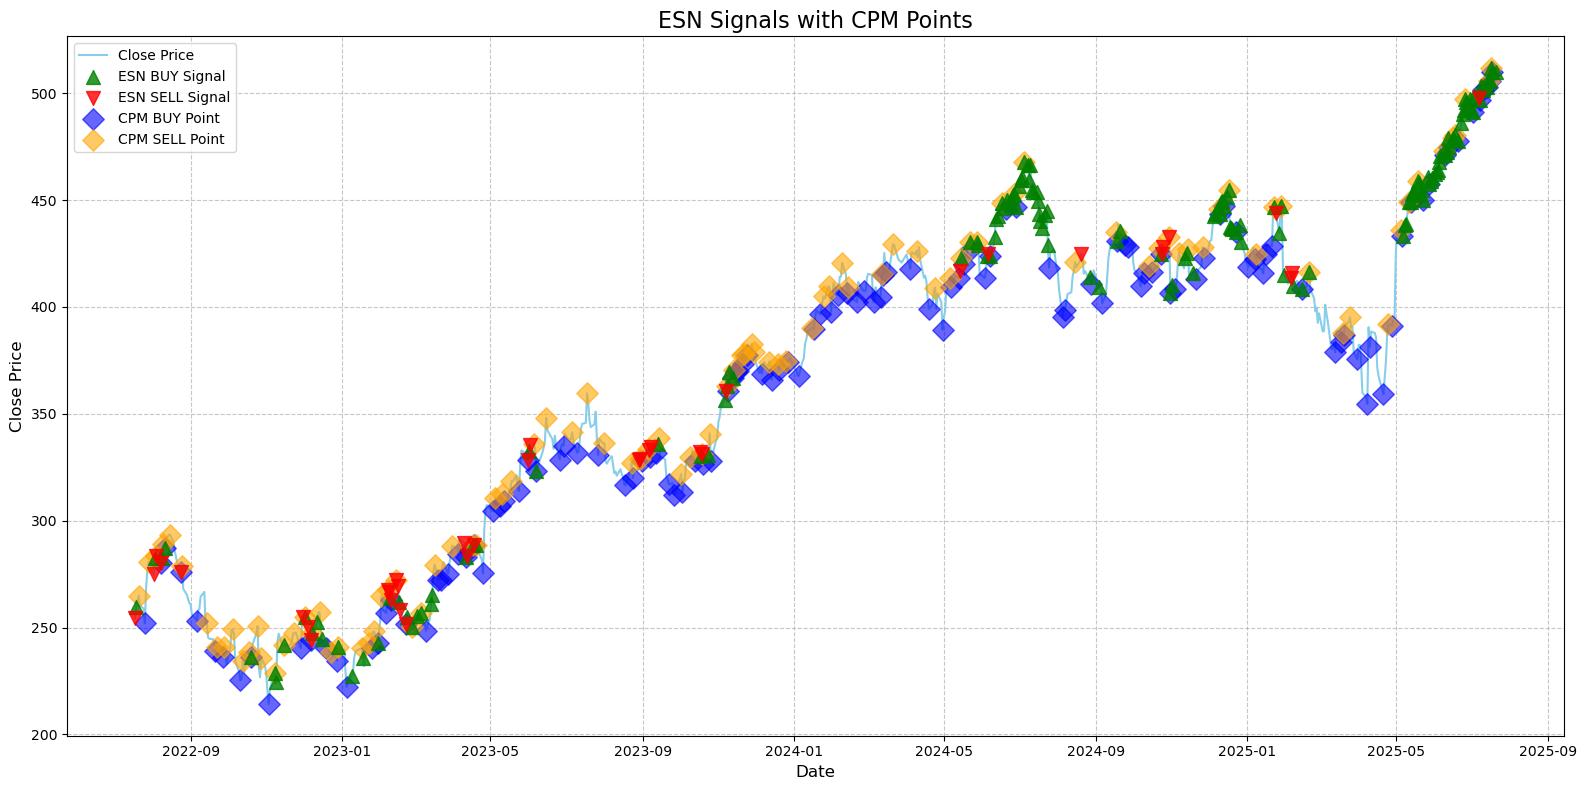

In [47]:
plot_signals(test_df, final_signals)